### Boxplots of daily total pieces/meter per region

__Purpose:__ Making static box plots for download

__Reference:__ Getting-data


In [1]:
import numpy as np
import json
import csv
import datetime
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from utilities.utility_functions import *
from utilities.scatterChart import scatterPlot


In [2]:
# index slicing will be used 
idx = pd.IndexSlice

# store the curent working directory
here = os.getcwd()

# name the folders where the output will be sored:
folders = ["data", "charts", "utilities"]

# check for existing and if not make folders
check_for_folders(folders, here)

# make a dictionary to call path by directory name
my_folders = make_folders(folders, here)
print(my_folders)

Directory already in place
{'data': '/home/mwshovel/dev/analyst/probability/data', 'charts': '/home/mwshovel/dev/analyst/probability/charts', 'utilities': '/home/mwshovel/dev/analyst/probability/utilities'}


In [3]:
# Read the JSON data in from local

# location of the data:
mlw_codes = json_file_get('/home/mwshovel/dev/analyst/probability/data/mlw_codes.json')
beach_data = json_file_get('/home/mwshovel/dev/analyst/probability/data/beach_data.json')
waterbody_groups = json_file_get('/home/mwshovel/dev/analyst/probability/data/waterbody_groups.json')

In [4]:
# transform the data and read in the survey results

# transform the the waterbody groups from an array to a python dictionary
water_body_names = {x['location']:x['beaches'] for x in waterbody_groups}

# transform the mlw codes from an array to a python dictionary 
codes_dict = {
    x['code']:{'description':x['description'], 'source':x['source'], 'material':x['material']}
    for x in mlw_codes
}

# Read in the .csv data
daily_totals = pd.read_csv('/home/mwshovel/dev/analyst/probability/data/daily_totals_pcs_m.csv')
survey_result = pd.read_csv('/home/mwshovel/dev/analyst/probability/data/survey_results.csv')

# make a timestamp column from the JSON string date
daily_totals['py_date'] = pd.to_datetime(daily_totals['date'])

In [5]:
# assign variables

# the location of interest:
water_body = 'Lac Léman'


# legend and title contents
title_content = 'Survey totals in pieces/meter'
figure_title = "Distribution of results {}".format(water_body)
legend_title = 'Object description: quantity'
chart_name = '{}-boxplots-2017-2018'.format('leman')

# provide a color map https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
color_map = 'winter'
point_size = 80
edge_c = 'white'

# get the relevant data
df_location = daily_totals[daily_totals['location'].isin(water_body_names[water_body])]

# if the data is inclusive and then identify locations and num samps here:
# or if this is for a sigle chart then do this in the for loop for the bxpstats

# locations = df_location['location'].unique()
# num_samps = len(df_location)
# num_locations = len(locations)

percentiles = [25, 50,75]
whis=[5,95]

In [6]:
# define the date range(s)
date_ranges = []
a_set_of_dates = [
    ('2017-04-01', '2018-05-01')    
]
for the_dates in a_set_of_dates:
    date_range = start_end_date(the_dates[0],the_dates[1], "%Y-%m-%d")
    date_ranges.append(date_range)


# apply date date range to df and make box plots
bxpstats = []
loactions_stats = []
for i,date_range in enumerate(date_ranges):
    data_by_dates = get_data_by_date_range(df_location, date_range)
    locations = data_by_dates['location'].unique()
    num_samps = len(data_by_dates)
    num_locations = len(locations)
    label='{} - {}'.format(a_set_of_dates[i][0], a_set_of_dates[i][1])
    an_array = data_by_dates.total.values
    data_quantiles = np.percentile(an_array, percentiles)
    whislo = np.percentile(an_array, 5)
    whishi = np.percentile(an_array, 95)
    box_stats = {
        'label':label,
        'med':data_quantiles[1],
        'q1':data_quantiles[0],
        'q3':data_quantiles[2],
        'whislo':whislo ,
        'whishi':whishi,
        'fliers':[x for x in an_array if x > data_quantiles[2] or x < data_quantiles[0]],     
        }    
    bxpstats.append(box_stats)    

vert = True

boxprops = dict(linestyle='-',
                linewidth=2,
                color='darkslategrey'
               )

capprops = dict(linestyle='-',
                   linewidth=2,
                   color='firebrick'
               )

flierprops = dict(marker='o',
                  markerfacecolor='navajowhite',
                  markersize=8,
                  markeredgecolor='darkslategrey',
                  alpha=0.5,
                  linestyle=None
                 )
medianprops = dict(linestyle='-',
                   linewidth=2,
                   color='firebrick'
                  )
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

figsize=(5,6)

# define the style and position for the chart title and the figure title
title_style = title_styles(fs=14,
                           ff='sans-serif',
                           fw='normal',
                           va='baseline',
                           ha='left'
                          )

# For sup title use :ff='sans-serif', fw='roman', fs=14, ha='left', va='baseline' 
sup_title_style = title_styles(fs=18,
                              ff='sans-serif',
                              fw='roman',
                              va='baseline',
                              ha='left'
                             )

# for the sup title position use x=0.13, pad=0
the_title_position = title_position(x=0, pad=15, y=.97)

sup_title_position = title_position(x=0.13, pad=0, y=.98)

# set the title and sup title content and color
the_title = title_content_color(content=title_content, color='black')

the_sup_title=title_content_color(content=figure_title, color='black')

# set the legend style and the location of the bounding box
the_legend_style = legend_style(title=legend_title)

# set the legend title and alignment
legend_title = legend_t_align()

# set the axis properties
y_axis = axis_label_props(label='Pieces of trash per meter of shoreline')

x_axis = axis_label_props(label='Results from the Swiss Litter Report')

# date formatters https://docs.python.org/3/library/datetime.html#datetime.datetime
x_tick_date = {
    "years":'%Y',
    "months":'%b',
    "days":'%a',
}
ticks = "months"
# adjust the distance from the top of the chart to the plotting area
subplot_params = adjust_subplot_params()

# file save paramteters
save_this = file_params(my_folders['charts'], chart_name, '.svg')

kwargs = {
    "figsize":figsize,
    "data_quantiles":data_quantiles,
    "bxpstats":bxpstats,
    "vert":vert,
    "whis":whis,
    "capprops":capprops,
    "boxprops":boxprops,
    "flierprops":flierprops,
    "medianprops":medianprops,
    "locations":locations,
    "num_samps":num_samps,
    "num_locations":num_locations,
    "title_style":title_style,
    "the_title_position":the_title_position,
    "the_title":the_title,
    "sup_title_style":sup_title_style,
    "sup_title_position":sup_title_position,
    "the_sup_title":the_sup_title,
    "the_legend_style":the_legend_style,
    "legend_title":legend_title,
    "y_axis":y_axis,
    "x_axis":x_axis,
    "subplot_params":subplot_params,
    "save_this":save_this,
    "point_size":point_size,
    "edge_c":edge_c,
    "x_tick_date":x_tick_date,
    "ticks":ticks    
 }


In [7]:
def boxPlot(**kwargs):
    
    fig, ax = plt.subplots(figsize=(kwargs['figsize']))
    
    number_of_samples= kwargs['num_samps']
    if(kwargs['num_locations'] > 1):
        plural_or_not = 'locations'
    else:
        plural_or_not = 'location'

    kwargs['the_title']["label"] = "{} samples from {} {}.".format(
        kwargs['num_samps'],
        kwargs['num_locations'],
        plural_or_not
    )
      
    ax.bxp(kwargs["bxpstats"],
           showfliers=True,
           flierprops=kwargs['flierprops'],
           medianprops=kwargs['medianprops'],
           boxprops=kwargs['boxprops'],
           capprops=kwargs['capprops']
           )

    plt.ylabel(kwargs['y_axis']['label'],
               fontfamily=kwargs['y_axis']['fontfamily'],
               labelpad=kwargs['y_axis']['lablepad'],
               color=kwargs['y_axis']['color'],
               size=kwargs['y_axis']['size']
              )

    plt.xlabel(kwargs['x_axis']['label'],
               fontfamily=kwargs['x_axis']['fontfamily'],
               labelpad=kwargs['x_axis']['lablepad'],
               color=kwargs['x_axis']['color'],
               size=kwargs['x_axis']['size'],
               ha='left',
               x=0
              )

    plt.subplots_adjust(**kwargs['subplot_params'])
    plt.title(**kwargs['the_title'], fontdict=kwargs['title_style'], **kwargs['the_title_position'])
    plt.suptitle(kwargs['the_sup_title']['label'],
                 fontsize=kwargs['sup_title_style']['fontsize'],
                 color=kwargs['the_sup_title']['color'],
                 x=kwargs['sup_title_position']['x'],
                 y=kwargs['sup_title_position']['y'],
                 ha=kwargs['sup_title_style']['horizontalalignment']
                )
    plt.grid(b=True, which='major', axis='both', color='grey', alpha=0.2)
  

    save_the_figure(**kwargs['save_this'])

    plt.show()
    plt.close()

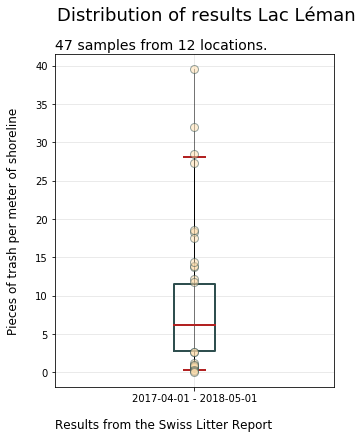

In [8]:
boxPlot(**kwargs)